# Visualizing Data with Snowflake
Data visualization is a key component of exploratory data analysis that is useful for data cleaning, identifying outliers and feature relationships, and so on. Interactive Python libraries like Matplotlib or Seaborn allow data scientists to draw fast insights, but when the data is stored in a cloud data warehouse such as Snowflake this is not possible.
## Visualizing the NYC Yellow Taxi Dataset
Our dataset is from a sample of NYC Yellow Taxi trip records on January 1st, 2015. We store this data in a Snowflake table and perform data transformations and visualizations using Matplotlib directly from this datastore.

The NYC Yellow Taxi dataset contains information regarding trips taken by passengers, including dropoff and pickup times, passenger count, tip amount, and total ride cost.
### Connecting to Snowflake
To start querying our data, we need to set up our Snowflake connection.

In [1]:
from pathlib import Path
import sys
from snowflake.snowpark import Session
import modin.pandas as pd
import snowflake.snowpark.modin.plugin

connection_parameters_path = str(Path("__file__").absolute().parent.parent.parent.parent)
sys.path.append(connection_parameters_path)
from tests.parameters import CONNECTION_PARAMETERS

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("data/yellow_tripdata_2015-01.csv", header=0)

In [3]:
df = df[df['PASSENGER_COUNT']>0]
df = df.drop(columns=['CONGESTION_SURCHARGE','AIRPORT_FEE'])

### Let's investigate the tip amounts. How much do people tip percentage wise based on their total charge?

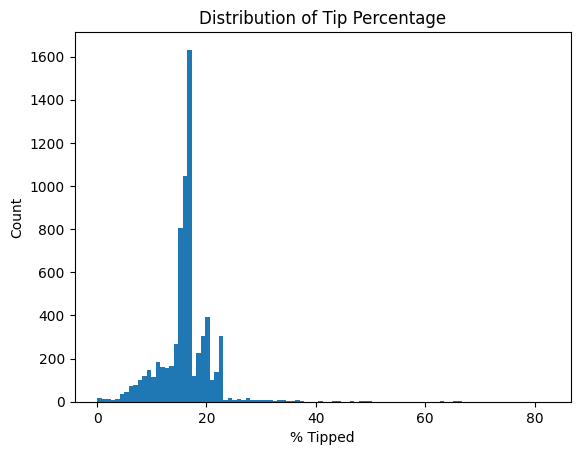

<Figure size 1500x300 with 0 Axes>

In [4]:
df2 = df.loc[df['TIP_AMOUNT']>0] 

fig, ax = plt.subplots()
plt.figure(figsize=(15, 3))
ax.hist(df2['TIP_AMOUNT']*100.0/df2['TOTAL_AMOUNT'], bins=100)
ax.set_title("Distribution of Tip Percentage")
ax.set_ylabel('Count')
ax.set_xlabel('% Tipped')
plt.show()

#### Here we see that most people tip 15-18% of their total taxi ride amount. We make sure to not include tip amounts equal to 0 as those would result in a zero division error.

#### Now let’s find the proportion of the number of passengers taking taxi rides. Pie charts are not that popular these days, but in honor of Pie Day just passing we feel obliged to include one.

In [5]:
df.groupby(['PASSENGER_COUNT']).count()

,VENDORID,TPEP_PICKUP_DATETIME,TPEP_DROPOFF_DATETIME,TRIP_DISTANCE,RATECODEID,STORE_AND_FWD_FLAG,PULOCATIONID,DOLOCATIONID,PAYMENT_TYPE,FARE_AMOUNT,EXTRA,MTA_TAX,TIP_AMOUNT,TOLLS_AMOUNT,IMPROVEMENT_SURCHARGE,TOTAL_AMOUNT
PASSENGER_COUNT,,,,,,,,,,,,,,,,
1,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587,9587
2,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724,2724
3,880,880,880,880,880,880,880,880,880,880,880,880,880,880,880,880
4,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492,492
5,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831
6,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485


In [6]:
df_passcount = df.groupby(['PASSENGER_COUNT']).count()['VENDORID']
df_passcount

PASSENGER_COUNT
1    9587
2    2724
3     880
4     492
5     831
6     485
Name: VENDORID, dtype: int64

Since this can be called by 3rd party libraries silently, it can lead to 
unexpected delays or high memory usage. Use to_pandas() or to_numpy() to do 
this once explicitly.


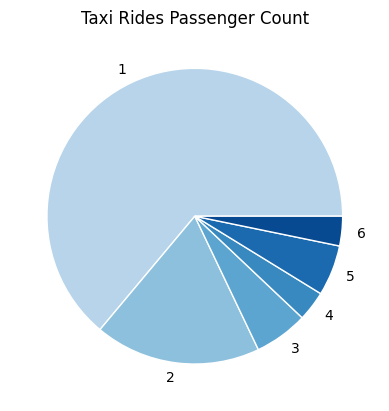

In [7]:
x = df_passcount
colors = plt.get_cmap('Blues')(np.linspace(0.3, 0.9, len(x)))

fig, ax = plt.subplots()
ax.pie(x, labels=df_passcount.index, colors=colors, 
       wedgeprops={"linewidth": 1, "edgecolor": "white"})

ax.set_title("Taxi Rides Passenger Count")
plt.show()

#### Interestingly, there are more solo rides than those with 2 passengers. Perhaps this is contributing to the NYC road congestion? Also, it looks like there are fewer trips with 4 riders than rides in a 5 seater taxi (or a 6 riders with legally assumes a child under 7 years is in a 5 seater taxi).

#### We can also see how the fare amounts change throughout the day based on the dropoff times.

Snowpark pandas to_datetime uses Snowflake's automatic format detection to convert string to datetime when a format is not provided. In this case Snowflake's auto format may yield different result values compared to pandas..


<Figure size 15000x500 with 0 Axes>

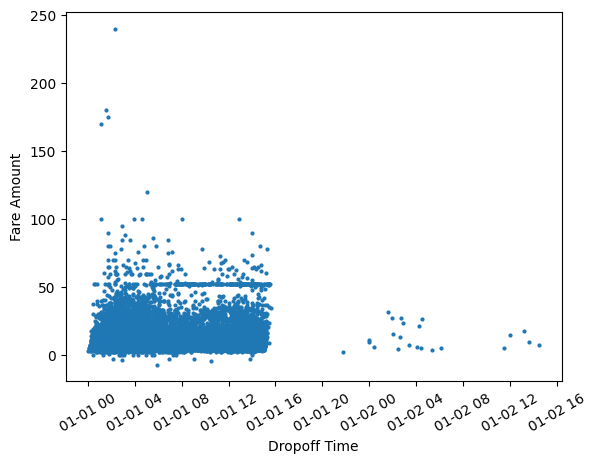

In [8]:
import matplotlib.dates as mdates

dropoff = pd.to_datetime(df.TPEP_DROPOFF_DATETIME)
plt.figure(figsize=(150, 5))
fig, ax = plt.subplots()
plt.xticks(rotation=30)

ax.set_xlabel('Dropoff Time')
ax.set_ylabel('Fare Amount')

ax.scatter(dropoff, df.FARE_AMOUNT, s=4)
plt.show()

#### Are those negative fare values? This shouldn’t be possible, so let’s clean our data and regenerate this visualization.

<Figure size 15000x500 with 0 Axes>

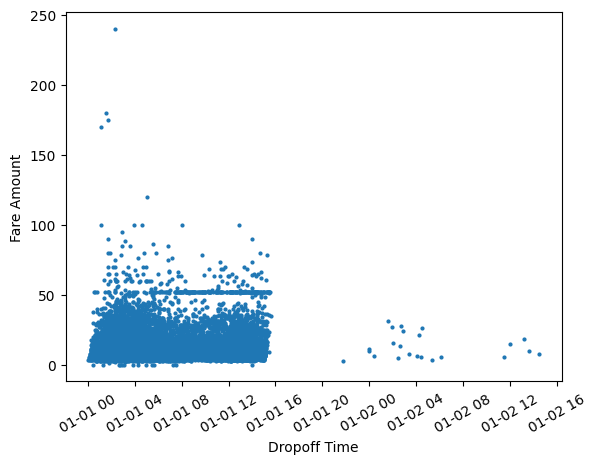

In [9]:
df = df[df['FARE_AMOUNT']>=0]

dropoff = pd.to_datetime(df.TPEP_DROPOFF_DATETIME)
plt.figure(figsize=(150, 5))
fig, ax = plt.subplots()
plt.xticks(rotation=30)

ax.set_xlabel('Dropoff Time')
ax.set_ylabel('Fare Amount')

ax.scatter(dropoff, df.FARE_AMOUNT, s=4)
plt.show()

#### That was fairly simple! We notice that the fares are higher with taxi drop off times closer to 12 AM. The sharp gap shows that there are much fewer trips made past 3 PM and rides pick up again towards midnight. This however reflects the sample of records taken from January 1st, 2015 rather than rider behavior.

#### Also, let’s take a moment to reflect on how straightforward it was to convert the TPEP_DROPOFF_DATETIME column to pandas datetime which Matplotlib can use to plot time series data out of the box.

#### How does the number of passengers impact trip cost features?

In [10]:
df_pass_tip_fare = df.groupby("PASSENGER_COUNT")[['FARE_AMOUNT', 'TIP_AMOUNT','TOLLS_AMOUNT', 'TOTAL_AMOUNT']].mean().reset_index()

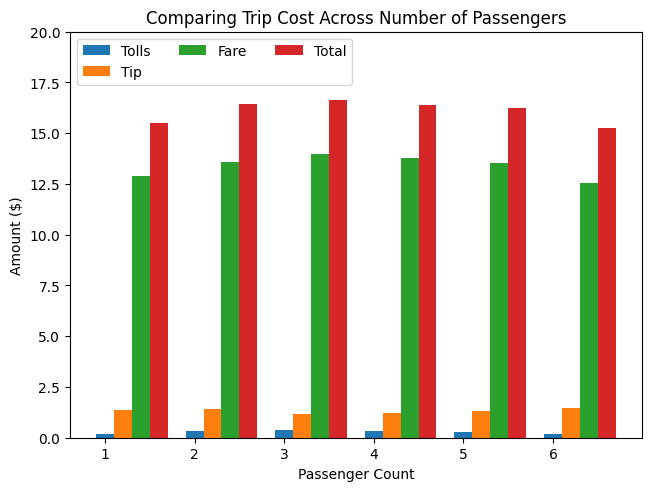

In [11]:
x = df_pass_tip_fare.PASSENGER_COUNT
y = {
    "Tolls": df_pass_tip_fare.TOLLS_AMOUNT.to_numpy(),
    "Tip": df_pass_tip_fare.TIP_AMOUNT.to_numpy(),
    "Fare": df_pass_tip_fare.FARE_AMOUNT.to_numpy(),
    "Total": df_pass_tip_fare.TOTAL_AMOUNT.to_numpy(),
}
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in y.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title("Comparing Trip Cost Across Number of Passengers")
ax.set_xlabel('Passenger Count')
ax.set_ylabel('Amount ($)')

ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 20)

plt.show()

#### We see that overall taxi costs are fairly uniform across passenger count. Since taxi fares are based on meters that calculate trip distance and time, this makes sense!

#### To find out if trip distance affects tip amounts, we can use hexagonal binning to plot density efficiently.

In [12]:
df_dist_less_30 = df[df["TRIP_DISTANCE"]<30]

x = df_dist_less_30.TRIP_DISTANCE
y = df_dist_less_30.TIP_AMOUNT

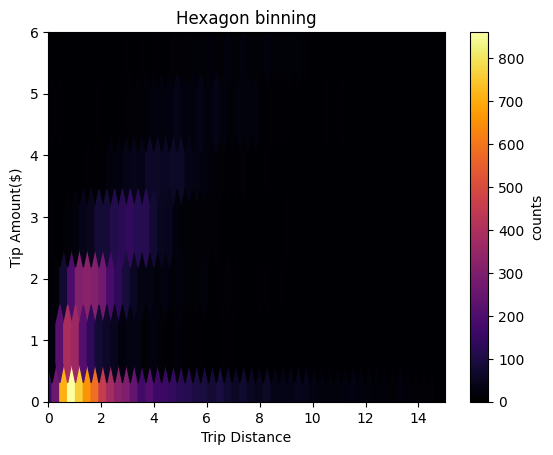

In [13]:
fig, ax = plt.subplots()

hb = ax.hexbin(x, y, cmap='inferno')

ax.set(xlim=(0, 15), ylim=(0, 6))
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Tip Amount($)')
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax, label='counts')
plt.show()

#### From this visualization, we see that while the tip amount generally increases with distance, the relationship is non-linear. There is also a significant occurrence of the tip remaining below $1 as distance increases. However, we must consider that this may not fully reflect NYC riders’ tipping behaviors as cash tips were not included in this dataset.

## Summary
In this post, we saw how easy it is to visualize data in your data warehouse using Ponder without needing to export data to any other format. All the pandas operations were running directly in Snowflake and we used Matplotlib to generate visualizations to iterate on findings. When irregularities were found, we could quickly clean our data using vanilla pandas and regenerate plots accordingly. No longer do users have to rerun SQL queries, download their data as a CSV file or Google Sheets, and connect to BI tools for exploratory data analysis.